#Base BERT with Replaced Hashtags


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! pip install sentencepiece
! pip install transformers
! pip install tensorflow-addons
! pip install tf-models-official
! pip install --upgrade tensorflow-hub

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.7/dist-packages (0.11.0)


In [ ]:
#Utility Functions
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re
import matplotlib.pyplot as plt

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

#Tensorflow Libraries
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
import tensorflow_hub as hub
from tensorflow.keras import utils

#from datetime import datetime

from collections import defaultdict

import sentencepiece

#Sk-learn functions
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel, T5Tokenizer, TFT5ForConditionalGeneration
from transformers import TFBertForSequenceClassification
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

In [ ]:
tf.get_logger().setLevel("ERROR")

###Load Data

In [ ]:
X_train_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/X_train.csv')
X_dev_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/X_dev.csv')
X_test_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/X_test.csv')
X_earlybird_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/X_earlybird.csv')
y_train_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/y_train.csv')
y_dev_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/y_dev.csv')
y_test_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/y_test.csv')
y_early_bird_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/y_earlybird.csv')

###Remove unneccessary columns and convert pandas dataframe to numpy array

In [ ]:
X_train_base = X_train_base['tweets']
X_dev_base = X_dev_base['tweets']
X_earlybird_base = X_earlybird_base['tweets']
X_test_base = X_test_base['tweets']
y_train_base = y_train_base['bot']
y_dev_base = y_dev_base['bot']
y_test_base = y_test_base['bot']
y_early_bird_base = y_early_bird_base['bot']
X_train_base, X_dev_base, y_train_base, y_dev_base = np.array(X_train_base),np.array(X_dev_base),np.array(y_train_base), np.array(y_dev_base)
X_test_base, y_test_base = np.array(X_test_base), np.array(y_test_base)

### Convert outcome variable to categorical

In [ ]:
def to_categorical(y_data):
  "Converts outcome to categorical"
  return utils.to_categorical(y_data)

y_train = to_categorical(y_train_base)
y_dev = to_categorical(y_dev_base)
y_test = to_categorical(y_test_base)
y_earlybird = to_categorical(y_early_bird_base)

### Encode Model

In [ ]:
def make_bert_layers():
  "Established Bert Process"
  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                             trainable=True)
  vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
  do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
  tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
  return bert_layer, vocab_file, do_lower_case, tokenizer

def encode_names(tweet, tokenizer):
   tokens = list(tokenizer.tokenize(tweet))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(tweet, tokenizer) for tweet in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

### Make Model

In [ ]:
def bert_model(max_length):
  "Makes Bert Model"
  bert_layer, vocab_file, do_lower_case, tokenizer= make_bert_layers()
  num_class = 2  # Based on available class selection
  max_length = max_length  # we calculated this a couple cells ago

  input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                

  output = tf.keras.layers.Dropout(rate=0.3)(pooled_output)

  output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='output')(output)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)
  return model, max_length, tokenizer
model, max_length, tokenizer = bert_model(200)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

### Visualize Model

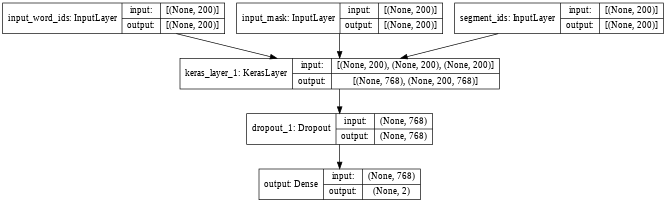

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

### Training Model Function

In [ ]:
def train_model_evaluate(X_train_encoded, X_dev_encoded, y_train, y_dev ,epochs, batch_size, loss_function):
  "Trains bert model"
  eval_batch_size = batch_size
  train_data_size = len(y_train)
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  warmup_steps = int(epochs * train_data_size * 0.1 / batch_size) 
  optimizer = nlp.optimization.create_optimizer(
    2e-6, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
  model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])
  model_history = model.fit(X_train_encoded,  # using new training set
                         y_train,  # using new training set
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(X_dev_encoded, y_dev),  # using old test dataset
                         verbose=1)
  return model_history

### Evaluate Model Function

In [ ]:
def evaluate_model(X_test_encoded, y_test, batch_size):
  "Evaluates on the test set"
  score, accuracy = model.evaluate(X_test_encoded, y_test, batch_size = batch_size)
  return score, accuracy

### Encode, Run, and Evaluate BERT Model with replaced hashtags

In [ ]:
X_train_base_no_hashtags = np.array([tweet.replace('#', '#hashtag') for tweet in X_train_base])
X_dev_base_no_hashtags = np.array([tweet.replace('#', '#hashtag') for tweet in X_dev_base])
X_test_base_no_hashtags = np.array([tweet.replace('#', '#hashtag') for tweet in X_test_base])








In [ ]:
X_train_encoded_no_hashtags = bert_encode(X_train_base_no_hashtags, tokenizer, max_length)
X_dev_encoded_no_hashtags = bert_encode(X_dev_base_no_hashtags, tokenizer, max_length)
X_test_encoded_no_hashtags = bert_encode(X_test_base_no_hashtags, tokenizer, max_length)

In [ ]:
model_history = train_model_evaluate(X_train_encoded_no_hashtags,X_dev_encoded_no_hashtags, y_train, y_dev, 1, 16, 'binary_crossentropy')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


17253/17253 [==============================] - 4785s 277ms/step - loss: 0.3370 - accuracy: 0.8575 - val_loss: 0.2006 - val_accuracy: 0.9391


In [ ]:
test_score, test_accuracy = evaluate_model(X_test_encoded_no_hashtags, y_test, 16)
test_score, test_accuracy

16500/16500 [==============================] - 1207s 73ms/step - loss: 0.6080 - accuracy: 0.8484


(0.6079661846160889, 0.8484204411506653)

### Save BERT Model with replaced Hashtags

In [ ]:
model_fname = 'bert_specified_hastags'
my_wd = '/content/gdrive/MyDrive/'

model.save(os.path.join(my_wd, model_fname))